# Hierarchical Partial Pooling

:::{post} Oct 07, 2021
:tags: hierarchical model, pymc3.Beta, pymc3.Binomial, pymc3.Deterministic, pymc3.Exponential, pymc3.Model, pymc3.Uniform
:category: intermediate
:::

Suppose you are tasked with estimating baseball batting skills for several players. One such performance metric is batting average. Since players play a different number of games and bat in different positions in the order, each player has a different number of at-bats. However, you want to estimate the skill of all players, including those with a relatively small number of batting opportunities.

So, suppose a player came to bat only 4 times, and never hit the ball. Are they a bad player?

As a disclaimer, the author of this notebook assumes little to non-existant knowledge about baseball and its rules. The number of times at bat in his entire life is around "4".


## Data

We will use the baseball [data](http://www.swarthmore.edu/NatSci/peverso1/Sports%20Data/JamesSteinData/Efron-Morris%20Baseball/EfronMorrisBB.txt) {cite:p}`efron1975data`.


## Approach

We will use PyMC3 to estimate the batting average for each player. Having estimated the averages across all players in the datasets, we can use this information to inform an estimate of an additional player, for which there is little data (*i.e.* 4 at-bats).

In the absence of a Bayesian hierarchical model, there are two approaches for this problem:

1. independently compute batting average for each player (no pooling)
2. compute an overall average, under the assumption that everyone has the same underlying average (complete pooling)

Of course, neither approach is realistic. Clearly, all players aren't equally skilled hitters, so the global average is implausible. At the same time, professional baseball players are similar in many ways, so their averages aren't entirely independent either. 

It may be possible to cluster groups of "similar" players, and estimate group averages, but using a hierarchical modeling approach is a natural way of sharing information that does not involve identifying *ad hoc* clusters.

The idea of hierarchical partial pooling is to model the global performance, and use that estimate to parameterize a population of players that accounts for differences among the players' performances. This tradeoff between global and individual performance will be automatically tuned by the model. Also, uncertainty due to different number of at bats for each player (*i.e.* informatino) will be automatically accounted for, by shrinking those estimates closer to the global mean.

For far more in-depth discussion please refer to Stan [tutorial](http://mc-stan.org/documentation/case-studies/pool-binary-trials.html) {cite:p}`carpenter2016hierarchical` on the subject. The model and parameter values were taken from that example.


In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

%matplotlib inline

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Now we can load the dataset using pandas:

In [3]:
data = pd.read_csv(pm.get_data("efron-morris-75-data.tsv"), sep="\t")
at_bats, hits = data[["At-Bats", "Hits"]].to_numpy().T

Now let's develop a generative model for these data.

We will assume that there exists a hidden factor (`phi`) related to the expected performance for all players (not limited to our 18). Since the population mean is an unknown value between 0 and 1, it must be bounded from below and above. Also, we assume that nothing is known about global average. Hence, a natural choice for a prior distribution is the uniform distribution.

Next, we introduce a hyperparameter `kappa` to account for the variance in the population batting averages, for which we will use a bounded Pareto distribution. This will ensure that the estimated value falls within reasonable bounds. These hyperparameters will be, in turn, used to parameterize a beta distribution, which is ideal for modeling quantities on the unit interval. The beta distribution is typically parameterized via a scale and shape parameter, it may also be parametrized in terms of its mean $\mu \in [0,1]$ and sample size (a proxy for variance) $\nu = \alpha + \beta (\nu > 0)$.

The final step is to specify a sampling distribution for the data (hit or miss) for every player, using a Binomial distribution. This is where the data are brought to bear on the model.

We could use `pm.Pareto('kappa', m=1.5)`, to define our prior on `kappa`, but the Pareto
distribution has very long tails. Exploring these properly
is difficult for the sampler, so we use an equivalent
but faster parametrization using the exponential distribution.
We use the fact that the log of a Pareto distributed
random variable follows an exponential distribution.

In [4]:
N = len(hits)
player_names = data["FirstName"] + " " + data["LastName"]
coords = {"player_names": player_names.tolist()}

with pm.Model(coords=coords) as baseball_model:

    phi = pm.Uniform("phi", lower=0.0, upper=1.0)

    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", tt.exp(kappa_log))

    theta = pm.Beta("theta", alpha=phi * kappa, beta=(1.0 - phi) * kappa, dims="player_names")
    y = pm.Binomial("y", n=at_bats, p=theta, dims = "player_names", observed=hits)

Recall our original question was with regard to the true batting average for a player with only 4 at bats and no hits. We can add this as an additional variable in the model

In [5]:
with baseball_model:

    theta_new = pm.Beta("theta_new", alpha=phi * kappa, beta=(1.0 - phi) * kappa)
    y_new = pm.Binomial("y_new", n=4, p=theta_new, observed=0)

The model can visualized like this

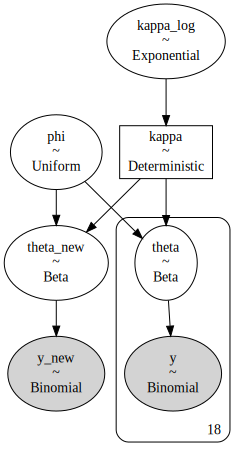

In [6]:
pm.model_to_graphviz(baseball_model)

We can now fit the model using MCMC:

In [7]:
with baseball_model:
    idata = pm.sample(2000, tune=2000, chains=2, target_accept=0.95, return_inferencedata=True)

    # check convergence diagnostics
    assert all(az.rhat(idata) < 1.03)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta_new, theta, kappa_log, phi]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.
The number of effective samples is smaller than 25% for some parameters.


0, dim: player_names, 18 =? 18


Now we can plot the posteriors distribution of the parameters. First, the population hyperparameters:

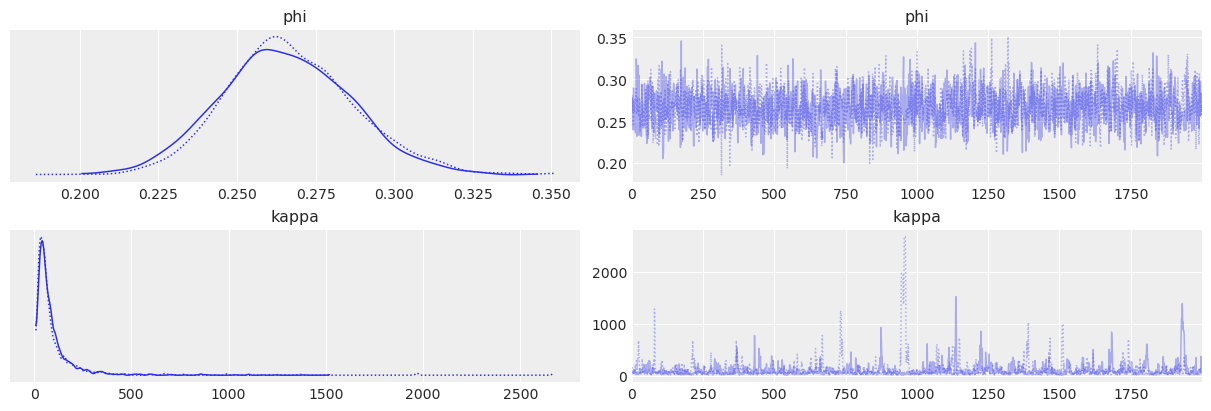

In [8]:
az.plot_trace(idata, var_names=["phi", "kappa"]);

Hence, the population mean batting average is in the 0.22-0.31 range, with an expected value of around 0.26.

Next, the estimates for all 18 players in the dataset:

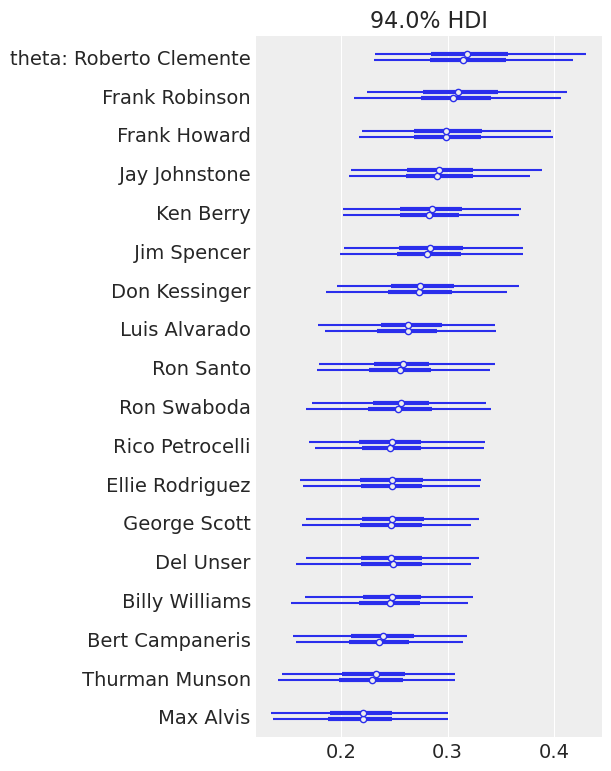

In [9]:
az.plot_forest(idata, var_names="theta");

Finally, let's get the estimate for our 0-for-4 player:

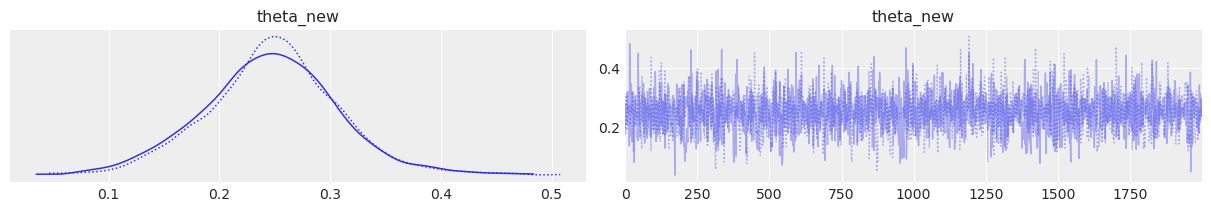

In [10]:
az.plot_trace(idata, var_names=["theta_new"]);

Notice that, despite the fact our additional player did not get any hits, the estimate of his average is not zero -- zero is not even a highly-probably value. This is because we are assuming that the player is drawn from a *population* of players with a distribution specified by our estimated hyperparemeters. However, the estimated mean for this player is toward the low end of the means for the players in our dataset, indicating that the 4 at-bats contributed some information toward the estimate.

In [11]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Sun Nov 21 2021

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

xarray: 0.19.0

numpy     : 1.21.4
theano    : 1.1.2
matplotlib: 3.5.0
pymc3     : 3.11.4
arviz     : 0.11.2
pandas    : 1.3.4

Watermark: 2.2.0



## References

:::{bibliography}
:filter: docname in docnames
:::
